# Data Science

We will train 5 different models in 2 experiments, and for each on eadjuste hiperparameters. Also, we will load every run into mlflow.

**Models**
* Logistic Regression
* Random Forest Classifier
* XGBoost Classifier
* Support Vector Classification
* Balanced Random Forest Classifier


### Libraries

In [114]:
from pprint import pprint

import matplotlib.pyplot as plt
import mlflow
import pandas as pd
import seaborn as sns
from imblearn.ensemble import BalancedRandomForestClassifier
from mlflow.models import infer_signature
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    classification_report,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from xgboost import XGBClassifier


### Load data

In [ ]:
# Comment once you run this line
%load_ext kedro.ipython
#%reload_kedro

[08/06/2025 01:08:57 a. m.] INFO     Resolved project path as: C:\Users\Esteban\Documents\.         __init__.py:180
                                     Clases_Tec\8. Octavo semestre\_Proyecto\kProject\tcaproject.                  
                                     To set a different path, run '%reload_kedro <project_root>'                   

[08/06/2025 01:08:58 a. m.] INFO     Registering new custom resolver: 'km.random_name'            mlflow_hook.py:65

                            INFO     Kedro is sending anonymous usage data with the sole purpose of   plugin.py:233
                                     improving the product. No personal data or IP addresses are                   
                                     stored on our side. If you want to opt out, set the                           
                                     `KEDRO_DISABLE_TELEMETRY` or `DO_NOT_TRACK` environment                       
                                     variables, or create a `.telemetry` file in the current working               
                                     directory with the contents `consent: false`. Read more at                    
                                     https://docs.kedro.org/en/stable/configuration/telemetry.html                 

                            INFO     Kedro project tcaProject                                       __init__.py:146

                            INFO     Defined global variable 'context', 'session', 'catalog' and    __init__.py:147
                                     'pipelines'                                                                   

                            INFO     Registered line magic 'run_viz'                                __init__.py:153

In [82]:
df_exp1 = catalog.load("reservaciones_exp1") # type: ignore # noqa: F821
df_exp2 = catalog.load("reservaciones_exp2") # type: ignore # noqa: F821

[08/06/2025 01:09:04 a. m.] INFO     Loading data from reservaciones_exp1 (ParquetDataset)...   data_catalog.py:403

                            INFO     Loading data from reservaciones_exp2 (ParquetDataset)...   data_catalog.py:403

### EDA

In [83]:
df_exp1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 202491 entries, 0 to 203001
Data columns (total 15 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   numero_personas                202491 non-null  float64
 1   numero_adultos                 202491 non-null  float64
 2   numero_menores                 202491 non-null  float64
 3   numero_noches                  202491 non-null  float64
 4   total_habitaciones             202491 non-null  float64
 5   reservacion_pendiente          202491 non-null  float64
 6   total_tarifa                   202491 non-null  float64
 7   reservacion                    202491 non-null  float64
 8   cancelacion                    202491 non-null  float64
 9   dias_llegada-reservacion       202491 non-null  float64
 10  dias_salida-llegada            202491 non-null  float64
 11  nombre_agencia_te              202491 non-null  float64
 12  ciudad_agencia_te              2024

In [84]:
df_exp2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199813 entries, 0 to 203001
Data columns (total 6 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   nombre_paquete          199813 non-null  float64
 1   ciudad_agencia          199813 non-null  float64
 2   nombre_tipo_habitacion  199813 non-null  float64
 3   nombre_canal            199813 non-null  float64
 4   nombre_estado           199813 non-null  float64
 5   cancelacion             199813 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 10.7 MB


In [85]:
print(df_exp1.isna().sum().sum())
print(df_exp2.isna().sum().sum())

0
0


**Correlation plots**

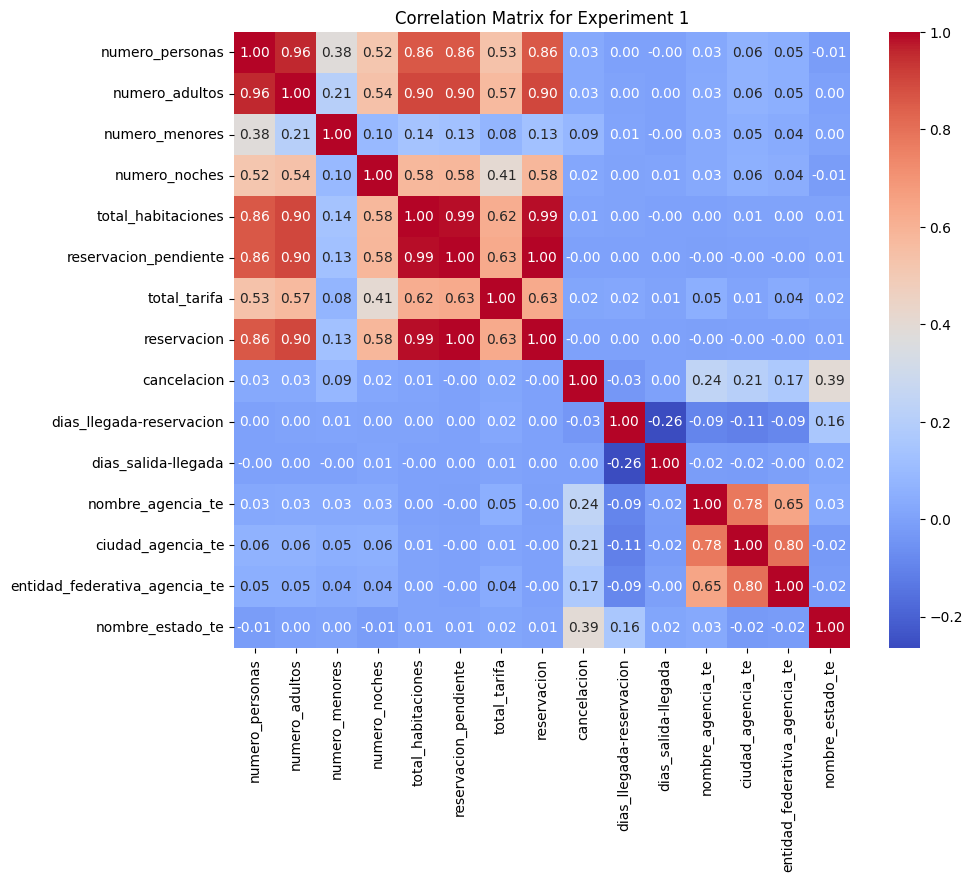

In [86]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_exp1.corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix for Experiment 1")
plt.show()

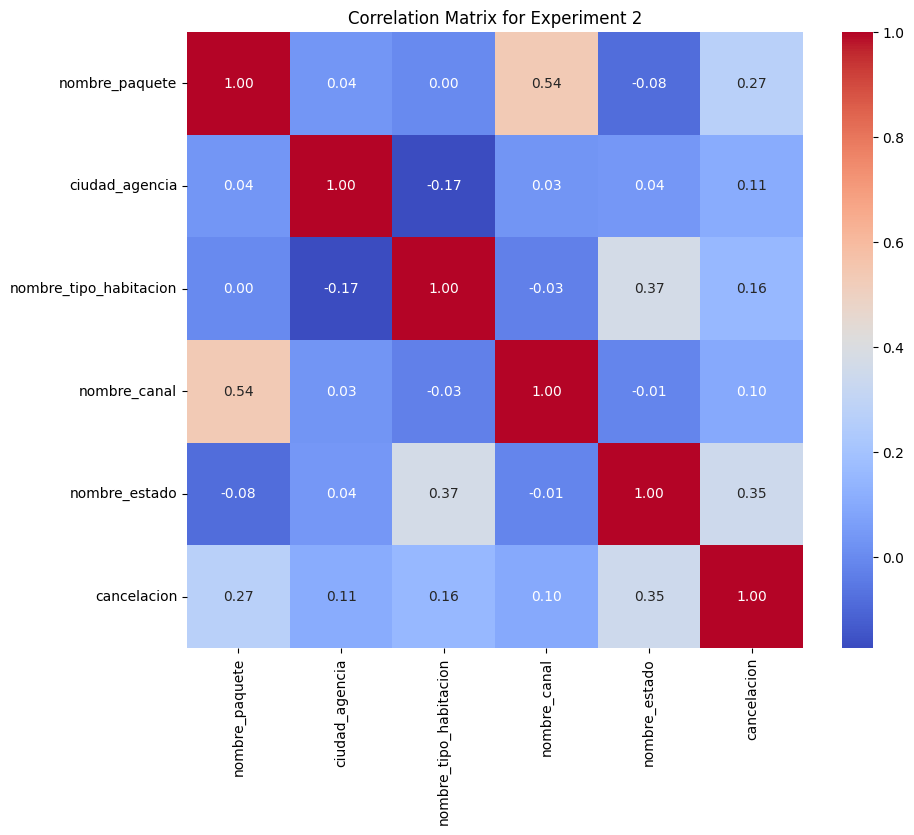

In [87]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_exp2.corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix for Experiment 2")
plt.show()

**Violin plots**

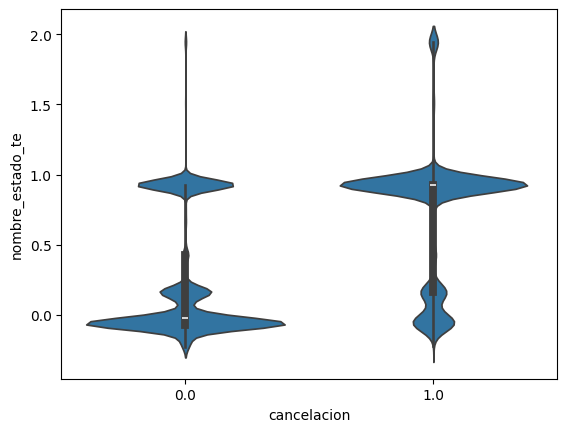

In [88]:
# Violint plot for each variable by cancelation
plt.figure()
sns.violinplot(x="cancelacion", y="nombre_estado_te", data=df_exp1)
plt.show()

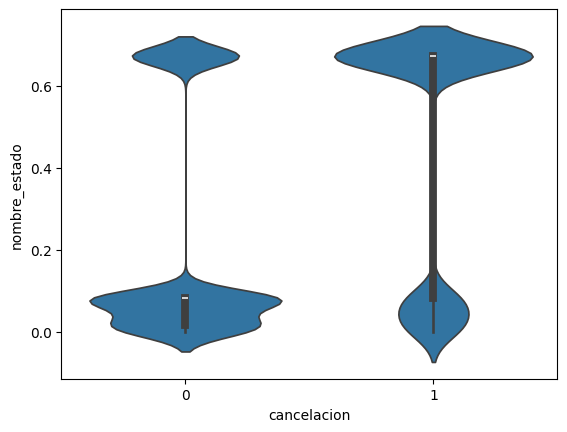

In [89]:
# Violint plot for each variable by cancelation
plt.figure()
sns.violinplot(x="cancelacion", y="nombre_estado", data=df_exp2)
plt.show()

### Train models and log into MLflow

**Train model: Experiment1**

In [116]:
# Define the target variable and independent variables
X = df_exp1.drop('cancelacion', axis=1)
y = df_exp1['cancelacion']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define logistic regression model
params = {
    'class_weight': 'balanced',
    'random_state': 42
    }

lr = LogisticRegression(**params)

lr.fit(X_train, y_train)

# Evaluation
y_pred = lr.predict(X_test)

print(classification_report(y_test, y_pred, target_names=['No Cancellation', 'Cancellation']))  # noqa: T201

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
y_scores = lr.predict_proba(X_test)[:, 1]
average_precision = average_precision_score(y_test, y_scores)
accuracy = accuracy_score(y_test, y_pred)

                 precision    recall  f1-score   support

No Cancellation       0.95      0.79      0.86     33896
   Cancellation       0.42      0.77      0.54      6603

       accuracy                           0.79     40499
      macro avg       0.68      0.78      0.70     40499
   weighted avg       0.86      0.79      0.81     40499



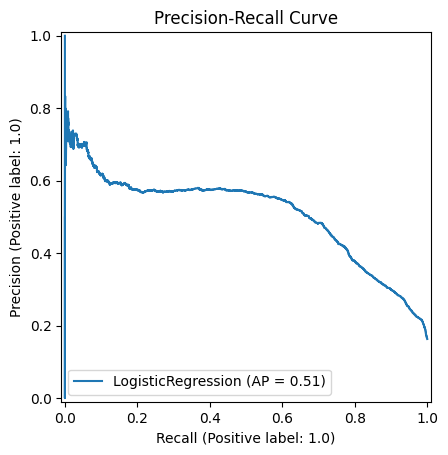

In [117]:
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_estimator(lr, X_test, y_test)
plt.title("Precision-Recall Curve")
plt.show()

**Log model: Experiment 1**

In [ ]:
# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")

# Create a new MLflow Experiment
mlflow.set_experiment("Experiment 1")

# Start an MLflow run
with mlflow.start_run():
    # Log the dataset
    #mlflow.log_artifact(datasets.load_iris())

    # Log the hyperparameters
    mlflow.log_params(params)

    # Log metrics
    metrics = {
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "average_precision": average_precision,
        "accuracy": accuracy
    }

    mlflow.log_metrics(metrics)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Info", "Basic Logistic Regression Model on reservaciones_exp1")

    # Infer the model signature
    signature = infer_signature(X_train, lr.predict(X_train))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=lr,
        artifact_path="reservaciones_exp1_model",
        signature=signature,
        input_example=X_train,
        registered_model_name="reservaciones_exp1_model"
    )

Registered model 'reservaciones_exp1_model' already exists. Creating a new version of this model...
2025/06/08 01:30:36 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: reservaciones_exp1_model, version 2


🏃 View run spiffy-lynx-567 at: http://127.0.0.1:5000/#/experiments/266921898870755520/runs/e93f516dc2e148a7b0e13ed4483a52bc
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/266921898870755520


Created version '2' of model 'reservaciones_exp1_model'.


**Train Model: Experment 2**

In [119]:
# Define the target variable and independent variables
X = df_exp2.drop('cancelacion', axis=1)
y = df_exp2['cancelacion']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define logistic regression model
params = {
    'class_weight': 'balanced',
    'random_state': 42
    }

lr = LogisticRegression(**params)

lr.fit(X_train, y_train)

# Evaluation
y_pred = lr.predict(X_test)

print(classification_report(y_test, y_pred, target_names=['No Cancellation', 'Cancellation']))  # noqa: T201

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = lr.score(X_test, y_test)
y_scores = lr.predict_proba(X_test)[:, 1]
average_precision = average_precision_score(y_test, y_scores)
accuracy = accuracy_score(y_test, y_pred)

                 precision    recall  f1-score   support

No Cancellation       0.96      0.84      0.89     33219
   Cancellation       0.51      0.81      0.62      6744

       accuracy                           0.84     39963
      macro avg       0.73      0.82      0.76     39963
   weighted avg       0.88      0.84      0.85     39963



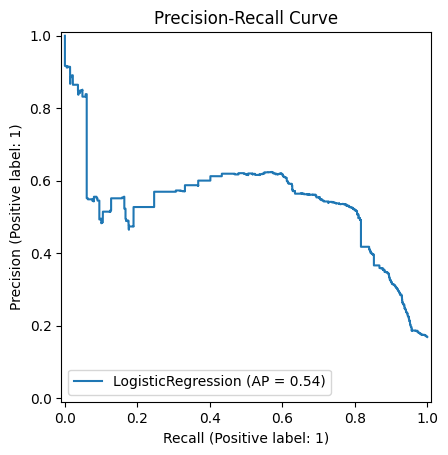

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_estimator(lr, X_test, y_test)
plt.title("Precision-Recall Curve")
plt.show()

**Log model: Experiment 2**

In [ ]:
# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")

# Create a new MLflow Experiment
mlflow.set_experiment("Experiment 2")

# Start an MLflow run
with mlflow.start_run():
    # Log the dataset
    #mlflow.log_artifact(datasets.load_iris())

    # Log the hyperparameters
    mlflow.log_params(params)

    # Log metrics
    metrics = {
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "average_precision": average_precision,
        "accuracy": accuracy
    }

    mlflow.log_metrics(metrics)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Info", "Basic Logistic Regression Model on reservaciones_exp1")

    # Infer the model signature
    signature = infer_signature(X_train, lr.predict(X_train))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=lr,
        artifact_path="reservaciones_exp2_model",
        signature=signature,
        input_example=X_train,
        registered_model_name="reservaciones_exp2_model"
    )

Registered model 'reservaciones_exp2_model' already exists. Creating a new version of this model...
2025/06/08 01:33:37 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: reservaciones_exp2_model, version 2


🏃 View run wise-asp-782 at: http://127.0.0.1:5000/#/experiments/629235308783576235/runs/dbf280018da94af78413c4952a0d93a4
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/629235308783576235


Created version '2' of model 'reservaciones_exp2_model'.
